In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import gurobipy as gp
from gurobipy import GRB
import cvxpy as cp

import random
from itertools import chain, combinations, tee
import time


# Load Input Data:

In [2]:
vot_pdf = np.genfromtxt('../original_code/VOT_distr.csv', delimiter=',')[1:]
vots = []
vot_p = []
for row in vot_pdf:
    vots.append(row[0])
    vot_p.append(row[1])
print(vot_p)
print()
vot_p=vot_p/np.sum(vot_p)
print(vot_p)

[0.01, 0.02, 0.01, 0.02, 0.02, 0.02, 0.02, 0.04, 0.02, 0.07, 0.02, 0.07, 0.16, 0.13, 0.05, 0.25, 0.03, 0.05]

[0.00990099 0.01980198 0.00990099 0.01980198 0.01980198 0.01980198
 0.01980198 0.03960396 0.01980198 0.06930693 0.01980198 0.06930693
 0.15841584 0.12871287 0.04950495 0.24752475 0.02970297 0.04950495]


# Travel time functions:

In [3]:
###### BPR Parameters ###### 
bpr_true_capacity = 66
bpr_true_fftt = 60*22/67
bpr_true_alpha = 0.2

def true_bpr_cost(flow_val, fftt = bpr_true_fftt, capacity = bpr_true_capacity, alpha = bpr_true_alpha):
    """
    Find the (exact) travel time on an edge given an edge flow
    """

    return fftt * (1+alpha*(flow_val/capacity)**6)

###### Approximation Parameters ###### 
const_multiplier = 1
cap_thresh_multiplier = 0.7835
apx_slope = 0.314

def apx_bpr_cost(flow_val, fftt = bpr_true_fftt, capacity = bpr_true_capacity, 
                a = const_multiplier, cap_thresh = cap_thresh_multiplier, b = apx_slope):
    """
    Find the (approximate) travel time on an edge given an edge flow
    """
    
    if flow_val <= cap_thresh*capacity:
        return a*fftt
    else:
        return a*fftt + b*(flow_val - cap_thresh*capacity)

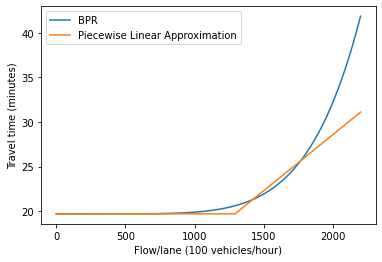

In [4]:
###### Check plots of BPR and approximation ###### 
multiplier = 100/4 # converts from 100 vehicles/hour --> vehicle/hour per lane

x =  np.linspace(0,int(np.round(88*multiplier,0)),int(np.round(89*2*multiplier,0)))
y = [true_bpr_cost(i, capacity = bpr_true_capacity*multiplier) for i in x]

plt.plot(x, y,label='BPR')

y_apx = [apx_bpr_cost(i,capacity = bpr_true_capacity*multiplier, b = apx_slope/multiplier) for i in x]

plt.plot(x, y_apx,label='Piecewise Linear Approximation')
plt.xlabel("Flow/lane (100 vehicles/hour)")
plt.ylabel("Travel time (minutes)")
plt.legend(loc='upper left')

# Generate Demand Profile:

In [5]:
###### Specify parameters for problem ###### 
T = 5 # Time Horizon
tau_arr = 20*np.linspace(0, 1, 21)[0:] # Toll discretization
print('Tau:\n {}'.format(tau_arr))
print()

B_arr = np.linspace(tau_arr[0], tau_arr[-3]*T,19) # Budget discretization 
print('B:\n {}'.format(B_arr))
print()

num_total = 8000 # number of users
num_eligible =int( num_total*.17) # number of eligible users
num_ineligible = num_total-num_eligible # number of ineligible users

###### VoT information ###### 
vot_all = np.sort(np.round(np.random.choice(vots, size = num_total, p=vot_p),2)/60) # generate baseline VoT for all users
vot_all_days = np.empty(shape=(num_total,T)) 
count=0
for v in vot_all:
    if count < num_eligible:
        vot_all_days[count,:]=[v for t in range(T)] # VoT of eligible users does not vary over time periods
    else:
        vot_all_days[count,:]=list((1+0.25*(np.random.random_sample(size=T)-0.5))*v) # VoT of ineligible users varies over time periods
    count+=1
    
vot_eligible = vot_all_days[:num_eligible,:]
vot_ineligible= vot_all_days[num_eligible:,:]

print('Eligible vot range:\n {} ({} $/hr), {} ({} $/hr)'.format(np.min(vot_eligible),60*np.min(np.round(vot_eligible,2)),np.max(np.round(vot_eligible,2)),60*np.max(np.round(vot_eligible,2))))
print()
print('Ineligible vot range:\n {}({} $/hr), {} ({} $/hr)'.format(np.min(np.round(vot_ineligible,2)),60*np.min(np.round(vot_ineligible,2)),np.max(np.round(vot_ineligible,2)),60*np.max(np.round(vot_ineligible,2))))
print()
print('Mean vot:\n {} $/hr; median: {} $/hr'.format(60*np.round(np.mean(vot_all_days),2),60*np.round(np.median(vot_all_days),2)))

Tau:
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]

B:
 [ 0.  5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70. 75. 80. 85.
 90.]

Eligible vot range:
 0.02 (1.2 $/hr), 0.24 (14.399999999999999 $/hr)

Ineligible vot range:
 0.21(12.6 $/hr), 2.7 (162.0 $/hr)

Mean vot:
 45.0 $/hr; median: 37.8 $/hr


Text(0, 0.5, '% of population')

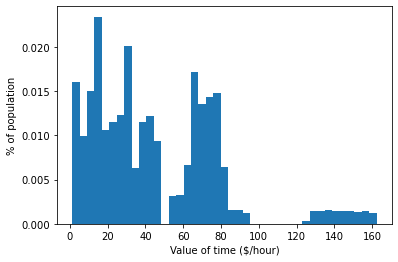

In [6]:
###### Check VoT distribution ###### 
plt.hist(vot_all_days.flatten()*60,bins=41,density=True)
plt.xlabel("Value of time ($/hour)")
plt.ylabel("% of population")

# Define Social Objectives of Interest:

In [7]:
###### Estimate VoT percentiles for ineligible group ###### 
percentiles = {}
thresh = 10
for p in range(11):
    print(np.round(np.percentile(vot_ineligible,p*10)*60,2))
    percentiles[p*10]=np.percentile(vot_ineligible,p*10)

12.62
18.03
23.43
30.25
37.75
44.51
63.84
68.86
74.86
80.45
162.26


# Solver 2, Discount:

In [9]:
# Solver 2, Discount:

def OptPL_discount(toll, discount_ratio, T = T, num_eligible = num_eligible, num_ineligible = num_ineligible, 
            vot_ineligible = vot_ineligible, alpha = bpr_true_alpha, fftt_1 = bpr_true_fftt, 
              fftt_2 = bpr_true_fftt, c_1 = bpr_true_capacity, c_2 = bpr_true_capacity, 
             a = const_multiplier, cap_thresh = cap_thresh_multiplier, b_1 = apx_slope, b_2 = apx_slope):
    """
    Function to solve convex optimization problem given a particular toll and budget value
    """
    
    # Initialize model
    m1 = gp.Model()
    # Add variables to model
#     users_in = m1.addVars(num_ineligible, 3, T, name = 'ineligible_val', lb = 0.0, ub = 2.0)
#     edge_flows = m1.addVars(2, T, name = 'edge_flows', lb = 0.0, ub = num_ineligible * 2.0)
#     users_el = m1.addVars(3, T, name = 'eligible_allocation', lb = 0.0, ub = 2.0)
    # Add variables for piecewise affine approximation
#     eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = 0.0, ub = num_ineligible * 2.0)
    
#     # Add variables for piecewise affine approximation
#     eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = 0.0, ub = num_ineligible * 2.0)
    users_in = m1.addVars(num_ineligible, 2, T, name = 'ineligible_val', lb = -10000.0, ub = 10000.0)
    edge_flows = m1.addVars(2, T, name = 'edge_flows', lb = -10000.0, ub = 10000.0)
    users_el = m1.addVars(2, T, name = 'eligible_allocation', lb = -10000.0, ub = 10000.0)
    eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = -10000.0, ub = 10000.0)   

    ## Add constraints to Model 
    
    # Total edge flow, express and general purpose lanes:
    m1.addConstrs((edge_flows[j, t] == sum(users_in[i, j, t] for i in range(num_ineligible)) + \
                  users_el[j, t] for j in range(2) for t in range(T)))
    
    # Non-negativity of flows, and zero flow for "eligible users in ineligible groups":
    m1.addConstrs((users_in[i, j, t]>=0 for i in range(num_ineligible) for j in range(2) for t in range(T)))
    m1.addConstrs((users_el[j, t]>=0 for j in range(2) for t in range(T)))
    
    # Every eligible and ineligible user is assigned to one of three options: \
    # (express paying, express with credit, non-express)
    m1.addConstrs((sum(users_in[i, j, t] for j in range(2)) == 1 for i in range(num_ineligible) for t in range(T)))
    m1.addConstrs((sum(users_el[j, t] for j in range(2)) == num_eligible for t in range(T)))
        
    # Piecewise affine approximation:
    m1.addConstrs((eps_flows[j, t] >= 0 for j in range(2) for t in range(T))) # Must be at least 0
    m1.addConstrs((eps_flows[0, t] >= edge_flows[0, t] - cap_thresh*c_1 for t in range(T))) # Must be at least flow - capacity
    m1.addConstrs((eps_flows[1, t] >= edge_flows[1, t] - cap_thresh*c_2 for t in range(T))) # Must be at least flow - capacity
    
    
    ## To edit below:
    # Set Objective
    m1.setObjective(sum( a*fftt_1*(edge_flows[0, t]) + b_1*(eps_flows[0, t]**2)/2  
                        + a*fftt_2*(edge_flows[1, t]) + b_2*(eps_flows[1, t]**2)/2 
                        + sum( toll*users_in[i,0,t]/vot_ineligible[i,t] for i in range(num_ineligible))
                        + sum( (1 - discount_ratio)*toll*users_el[0,t]/vot_eligible[i,t] for i in range(num_eligible))
        for t in range(T)), GRB.MINIMIZE)
    
    m1.update()
    
    return m1

In [10]:
def _extract_solution_discount(m, num_ineligible = num_ineligible):
    """
    Get solution from optimization model
    """
    users_in = [v.x for v in m.getVars() if v.VarName.find("ineligible_val") != -1]
    users_el = [v.x for v in m.getVars() if v.VarName.find("eligible_allocation") != -1]
    edge_flows = [v.x for v in m.getVars() if v.VarName.find("edge_flows") != -1]
    eps_flows = [v.x for v in m.getVars() if v.VarName.find("eps_flows") != -1]
    
    users_in = np.reshape(users_in, (num_ineligible, 2, T))
    users_el = np.reshape(users_el, (2, T))
    edge_flows = np.reshape(edge_flows, (2, T))
    eps_flows = np.reshape(eps_flows, (2, T))

    solution = {
        "users_in": users_in,
        "users_el": users_el,
        "edge_flows": edge_flows,
        "eps_flows": eps_flows
    }
    return solution

In [15]:
def to_str(num):
    num = int(num)
    
    # For any number < 100:
    if num < 10:
        return str(0) + str(num)
    else:
        return str(num)

# Solve Optimization Problem for Discretized Grid:

## Case 2 - Discount:

In [16]:
# tau_arr = 20 * np.linspace(0, 1, 21)[0:] # Toll discretization
# B_arr = np.linspace(tau_arr[0], tau_arr[-3]*T,19) # Budget discretization 
# print(tau_arr)
# print()
# print(B_arr)
# print()

In [17]:
t_1 = time.time()

demand_multiplier = [25,75]

# For saving data:
path_directory = "/Users/chih-yuanchiu/Desktop/Code/CBCP_Credit_Discount/data_discount/"

row_names = ["Edge flows", "Eps flows", "Eligible User Flows"]
row_names += ["Ineligible User Flow, " + str(k) for k in list(range(num_ineligible + 1))[1:]]

column_names = []
workday_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
lane_names = ["Express", "General Purpose"]
for workday_index, workday in enumerate(workday_names):
    for lane_index, lane in enumerate(lane_names):
        column_names.append(workday + ", " + lane)

# Copied from above:
# tau_arr = 20 * np.linspace(0, 1, 21)[0:] # Toll discretization
# B_arr = np.linspace(tau_arr[0], tau_arr[-3]*T,19) # Budget discretization 

## For debugging purposes, truncate tau_arr and B_arr:
# tau_arr = [0.0, 5.0, 10.0, 15.0, 20.0]
# B_arr = [0.0, 5.0, 10.0, 15.0, 20.0]
# tau_arr = [20]
tau_arr = 20 * np.linspace(0, 1, 11)[0:] 
B_arr = np.linspace(0, tau_arr[-1]*4, 9)
# tau_arr = [2.0]
# B_arr = [0.0]



total_count = len(tau_arr) * len(B_arr)


for toll_idx, toll in enumerate(tau_arr):
    for budget_idx, budget in enumerate(B_arr):
        
        discount_ratio = budget/(toll*T) if (toll != 0 and budget < toll*T) else 1
        print()
        print("Toll:", toll)
        print("Budget:", budget)
        print("Discount Ratio:", discount_ratio)
        print()
        
        m_discount = OptPL_discount(toll, discount_ratio, T = T, num_eligible = num_eligible, num_ineligible = num_ineligible, 
                    vot_ineligible = vot_ineligible, alpha = bpr_true_alpha, fftt_1 = bpr_true_fftt, 
                      fftt_2 = bpr_true_fftt, c_1 = bpr_true_capacity*demand_multiplier[0], c_2 = bpr_true_capacity*demand_multiplier[1], 
                     a = const_multiplier, cap_thresh = cap_thresh_multiplier, b_1 = apx_slope/demand_multiplier[0], b_2 = apx_slope/(demand_multiplier[1]))

        m_discount.optimize()
        
        # Extract Solution:
        solution_set = _extract_solution_discount(m_discount)
        
        if toll == tau_arr[0]:
            print()
            print("Edge flows:", solution_set["edge_flows"])
            print()
            
        ### Frank - To modify below:
        # Storing data:
        data_edge_flows = solution_set["edge_flows"].T.reshape(10)
        data_eps_flow = solution_set["eps_flows"].T.reshape(10)
        data_users_el = solution_set["users_el"].T.reshape(10)
        data_users_in = solution_set["users_in"].transpose(0, 2, 1).reshape((num_ineligible, 5*2))
        data = np.vstack((data_edge_flows, data_eps_flow, data_users_el, data_users_in))
        
        file_name = path_directory + "toll_" + to_str(toll) + "_budget_" + to_str(budget) + ".csv"
        df = pd.DataFrame(data, columns = column_names, index = row_names)        
        df.to_csv(file_name)
        
                

t_2 = time.time()
print("Run time:", t_2 - t_1)


Toll: 0.0
Budget: 0.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x4f369e61
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 66410 columns
Presolve time: 0.13s
Presolved: 15 rows, 20 columns, 30 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual  

KeyboardInterrupt: 

In [ ]:
# print("num_total:", num_total)
# print("num_eligible:", num_eligible)
# print("num_ineligible:", num_ineligible)
# print("toll:", toll)
# print("budget:", budget)
# print("num_eligible:", num_eligible)
# print("num_ineligible_trunc:", num_ineligible_trunc)
# print("vot_ineligible:", vot_ineligible)
# print("alpha:", bpr_true_alpha)
# print("fftt_1:", bpr_true_fftt)
# print("fftt_2:", bpr_true_fftt)
# print("c_1:", bpr_true_capacity*demand_multiplier[0])
# print("c_2:", bpr_true_capacity*demand_multiplier[1])
# print("a:", const_multiplier)
# print("cap_thresh:", cap_thresh_multiplier)
# print("b_1:", apx_slope/demand_multiplier[0])
# print("b_2:", apx_slope/demand_multiplier[1])
# print()

In [ ]:
solution_gurobi.keys()

In [ ]:
solution_gurobi = _extract_solution_discount(m_discount)

print(solution_gurobi["edge_flows"].shape)
print()
print(solution_gurobi["eps_flows"].shape)
print()
print(solution_gurobi["users_in"].shape)
print()
print(solution_gurobi["users_el"].shape)



In [ ]:
# print("num_total:", num_total)
# print("num_eligible:", num_eligible)
# print("num_ineligible:", num_ineligible)



## Discount, Test:

In [ ]:
time_1 = time.time()


demand_multiplier = [25,75]

# num_ineligible_trunc = num_ineligible

# Truncating num_ineligible to enable comparison with CVXPY (which is very, very slow):
# num_ineligible_trunc = 200
# num_ineligible_trunc = int(num_ineligible/3)
num_ineligible_trunc = num_ineligible
discount_ratio = budget/(toll*T)

# toll = 1.0
# budget = 3.0

# print("num_total:", num_total)
# print("num_eligible:", num_eligible)
# print("num_ineligible:", num_ineligible)
# print("toll:", toll)
# print("budget:", budget)
# print("num_eligible:", num_eligible)
# print("num_ineligible_trunc:", num_ineligible_trunc)
# print("vot_ineligible:", vot_ineligible)
# print("alpha:", bpr_true_alpha)
# print("fftt_1:", bpr_true_fftt)
# print("fftt_2:", bpr_true_fftt)
# print("c_1:", bpr_true_capacity*demand_multiplier[0])
# print("c_2:", bpr_true_capacity*demand_multiplier[1])
# print("a:", const_multiplier)
# print("cap_thresh:", cap_thresh_multiplier)
# print("b_1:", apx_slope/demand_multiplier[0])
# print("b_2:", apx_slope/demand_multiplier[1])
# print()


m_discount = OptPL_discount(toll, discount_ratio, T = T, num_eligible = num_eligible, num_ineligible = num_ineligible_trunc, 
            vot_ineligible = vot_ineligible, alpha = bpr_true_alpha, fftt_1 = bpr_true_fftt, 
              fftt_2 = bpr_true_fftt, c_1 = bpr_true_capacity*demand_multiplier[0], c_2 = bpr_true_capacity*demand_multiplier[1], 
             a = const_multiplier, cap_thresh = cap_thresh_multiplier, b_1 = apx_slope/demand_multiplier[0], b_2 = apx_slope/(demand_multiplier[1]))

m_discount.optimize()

time_2 = time.time()
print("Run time:", time_2 - time_1)

In [ ]:
solution_discount = _extract_solution_discount(m_discount)

In [ ]:
print(solution_discount["edge_flows"])
print()
print(solution_discount["eps_flows"])



# Scratch Work:

In [ ]:
# 20*np.linspace(0, 1, 21)[0:]
# np.linspace(toll_arr[0], toll_arr[-3]*T,19)